In [34]:
#!pip install --quiet glvis
import numpy as np
import matplotlib.pyplot as plt
from  bfp import *
import mfem.ser as mfem
#from mfem.common.arg_parser import ArgParser
from glvis import glvis, GlvisData
import seaborn as sns


In [35]:
def save_angular_flux(psi, mu):
    """Saves the flux solution psi for a specific mu value to a file.

    Args:
        psi (mfem.GridFunction): The flux solution to save.
        mu (float): The mu value associated with this flux solution.
    """
    filename = "psi_mu_{:.4f}.gf".format(mu)
    psi.Save(filename)

def assemble_system(fes, marker, xs_t_coeff, dS_dE_coeff, q_coeff, v_coeff, inflow_coeff):       
    a = mfem.BilinearForm(fes)
    a.AddDomainIntegrator(mfem.ConvectionIntegrator(v_coeff))
    a.AddDomainIntegrator(mfem.MassIntegrator(xs_t_coeff))
    a.AddDomainIntegrator(mfem.MassIntegrator(dS_dE_coeff))
    a.AddInteriorFaceIntegrator(mfem.TransposeIntegrator(mfem.DGTraceIntegrator(v_coeff, 1.0, -0.5)))
    a.AddBdrFaceIntegrator(mfem.TransposeIntegrator(mfem.DGTraceIntegrator(v_coeff, 1.0, -0.5)))
    a.Assemble()
    a.Finalize()
    A = a.SpMat()

    b = mfem.LinearForm(fes)
    b.AddDomainIntegrator(mfem.DomainLFIntegrator(q_coeff))
    b.AddBdrFaceIntegrator(mfem.BoundaryFlowIntegrator(inflow_coeff, v_coeff, -1.0), marker)
    #b.AddDomainIntegrator(mfem.DomainLFIntegrator(scattering_source))
    b.Assemble()

    return A, b

def set_solver(fes, A, b, mu):
    psi = mfem.GridFunction(fes)
    psi.Assign(1.0) 
    prec = mfem.GSSmoother(A)
    solver = mfem.GMRESSolver()
    solver.SetOperator(A)
    solver.SetPreconditioner(prec)
    solver.SetRelTol(1e-12)
    solver.SetAbsTol(1e-12)
    solver.SetMaxIter(500)
    solver.SetKDim(30)
    solver.SetPrintLevel(0)
    solver.Mult(b, psi)
   
    #psi_mu_list.append((mu, w, psi))
    
    save_angular_flux(psi, mu)
    return psi

def solve_system_for_angle(mu_vals, w_vals, mesh, fes, xs_t_coeff, S_coeff, dS_dE_coeff, q_coeff, inflow_coeff):
    psi_mu_list = []
    for mu, w in zip(mu_vals, w_vals):
        print("  Solving for mu =", mu)
        marker = get_marker_for_mu(mesh, mu)
        v_coeff = VelocityCoefficient2(mu, S_coeff)
        #v_coeff = VelocityCoefficientOld(mu, S_arr)

        A, b = assemble_system(fes, marker, xs_t_coeff, dS_dE_coeff, q_coeff, v_coeff, inflow_coeff)
        psi = set_solver(fes, A, b, mu)
        psi_mu_list.append((mu, w, psi))
    phi = mfem.GridFunction(fes)
    phi.Assign(0.0)
    for mu, w, psi in psi_mu_list:
        phi.Add(w, psi)

    phi.Save("phi.gf")
    return phi



In [ ]:
# Set parameters
nx = 3
nE = 5
x_start = 0.0
x_end = 0.3
E_start = 1
E_end = 0.01
N_ang = 2
order = 1

mesh = create_2D_mesh(nx, nE, x_start, x_end, E_start, E_end)
dim = mesh.Dimension()
assign_boundary_attributes(mesh, x_start, E_start, x_end, tol=1e-6)

fec = mfem.DG_FECollection(order, dim)
fes = mfem.FiniteElementSpace(mesh, fec)
Size = fes.GetVSize()
print("Number of unknowns:", Size)

mu_vals, w_vals = gauss_legendre_dirs(N_ang)

S_arr = np.zeros(nE)
E_arr = np.linspace(E_start, E_end, nE+1)
xs_t_coeff = TotalXSCoefficient(5)
xs_s_coeff = ScatteringXSCoefficient(0)
S_coeff    = StoppingPowerCoefficient(0)
dS_dE_arr = np.zeros(nE)
dS_dE_coeff = StoppingPowerDerivativeCoefficient(0)
q_coeff = ConstantCoefficient(100)
inflow_coeff = ConstantCoefficient(0)
    
psi_mu_list = []

for mu, w in zip(mu_vals, w_vals):
    print("  Solving for mu =", mu)
    marker = get_marker_for_mu(mesh, mu)
    v_coeff = VelocityCoefficient(mu, S_arr, E_start, E_end)

    a = mfem.BilinearForm(fes)
    a.AddDomainIntegrator(mfem.ConvectionIntegrator(v_coeff))
    a.AddDomainIntegrator(mfem.MassIntegrator(xs_t_coeff))
    a.AddDomainIntegrator(mfem.MassIntegrator(dS_dE_coeff))
    a.AddInteriorFaceIntegrator(mfem.TransposeIntegrator(mfem.DGTraceIntegrator(v_coeff, 1.0, -0.5)))
    a.AddBdrFaceIntegrator(mfem.TransposeIntegrator(mfem.DGTraceIntegrator(v_coeff, 1.0, -0.5)))
    a.Assemble()
    a.Finalize()
    A = a.SpMat()

    b = mfem.LinearForm(fes)
    b.AddDomainIntegrator(mfem.DomainLFIntegrator(q_coeff))
    b.AddBdrFaceIntegrator(mfem.BoundaryFlowIntegrator(inflow_coeff, v_coeff, -1.0), marker)
    #b.AddDomainIntegrator(mfem.DomainLFIntegrator(scattering_source))
    b.Assemble()

    psi = mfem.GridFunction(fes)
    psi.Assign(1.0) 
    prec = mfem.GSSmoother(A)
    solver = mfem.GMRESSolver()
    solver.SetOperator(A)
    solver.SetPreconditioner(prec)
    solver.SetRelTol(1e-12)
    solver.SetAbsTol(1e-12)
    solver.SetMaxIter(500)
    solver.SetKDim(30)
    solver.SetPrintLevel(0)
    solver.Mult(b, psi)

    
    # Append the angular solution for mu
    psi_mu_list.append((mu, w, psi))
    
    # Save each angular solution and corresponding mesh.
    psi.Save("psi_mu_list{:.3f}.gf".format(mu))

phi = mfem.GridFunction(fes)
phi.Assign(0.0)
for mu, w, psi in psi_mu_list:
    phi.Add(w, psi)

phi.Save("phi_newww.gf")
    

File '/Users/melekderman/github/BFP/examples/mesh/usr/1x2_2D.mesh' already exists.
Number of unknowns: 8
  Solving for mu = -0.8611363115940526
  Solving for mu = -0.33998104358485626
  Solving for mu = 0.33998104358485626
  Solving for mu = 0.8611363115940526


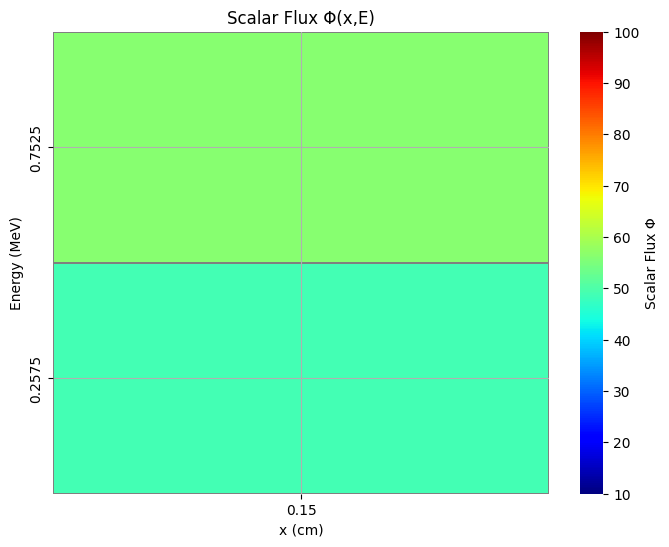

In [46]:

HeatMap = HeatmapPlot(phi, mesh, fes)
HeatMap.plot_heatmap(x_start, x_end, nx, E_start, E_end, nE, vmin=10, vmax=100)

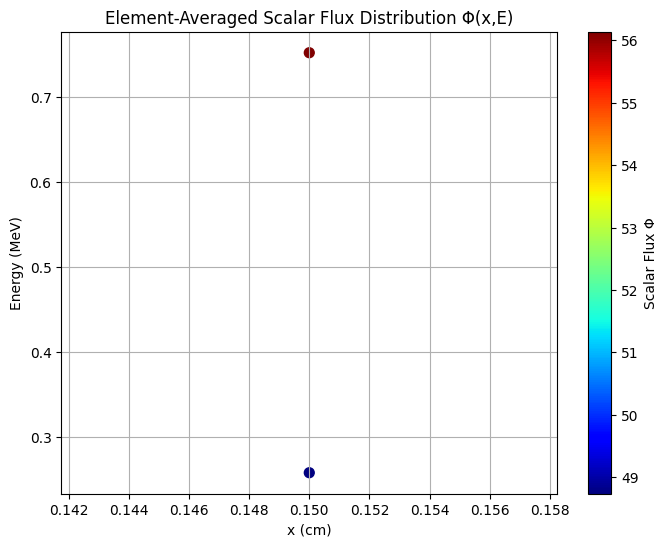

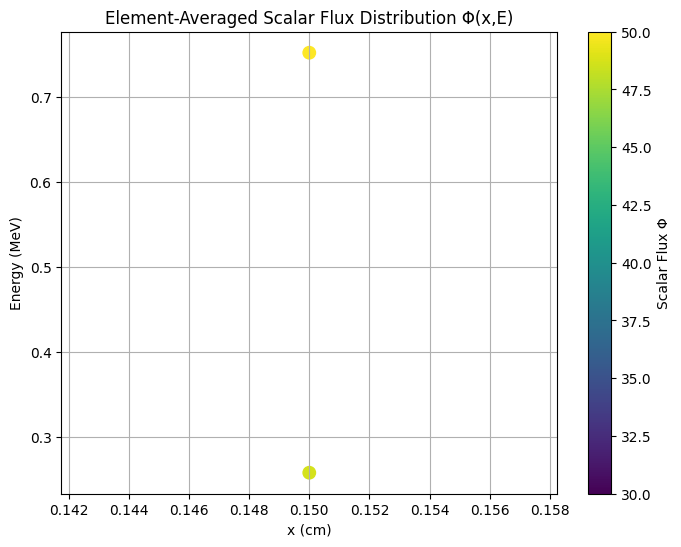

In [44]:
Scatter = ScatterPlot(phi, mesh, fes)
Scatter.plot_scatter()
Scatter.plot_scatter(cmap='viridis', point_size=80, vmin=30, vmax=50)


In [45]:
print(q_coeff.EvalValue([0, 0.5]))


100


In [40]:
print(mesh.GetNE())  # eleman sayısını kontrol et
print(mesh.Dimension()) # dimension kontrolü


200
2


In [41]:
point = [0.1, 0.5]
print("S_coeff", S_coeff.EvalValue(point))
print("xs_t_coeff", xs_t_coeff.EvalValue(point))
print("dS_dE_coeff", dS_dE_coeff.EvalValue(point))


S_coeff 0.0
xs_t_coeff 5.0
dS_dE_coeff 0.0
